<a href="https://colab.research.google.com/github/julianafalves/Generative-AI-using-Tensorflow/blob/main/Generative_AI_using_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Importing data  and dependencies

In [1]:
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
#Bringing dependencies
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np

In [4]:
#importing fashion dataset
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteT9FQJ6/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteT9FQJ6/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

# Vizualizing data

In [6]:
#Setup connection through iterator
dataiterator = ds.as_numpy_iterator()

In [7]:
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

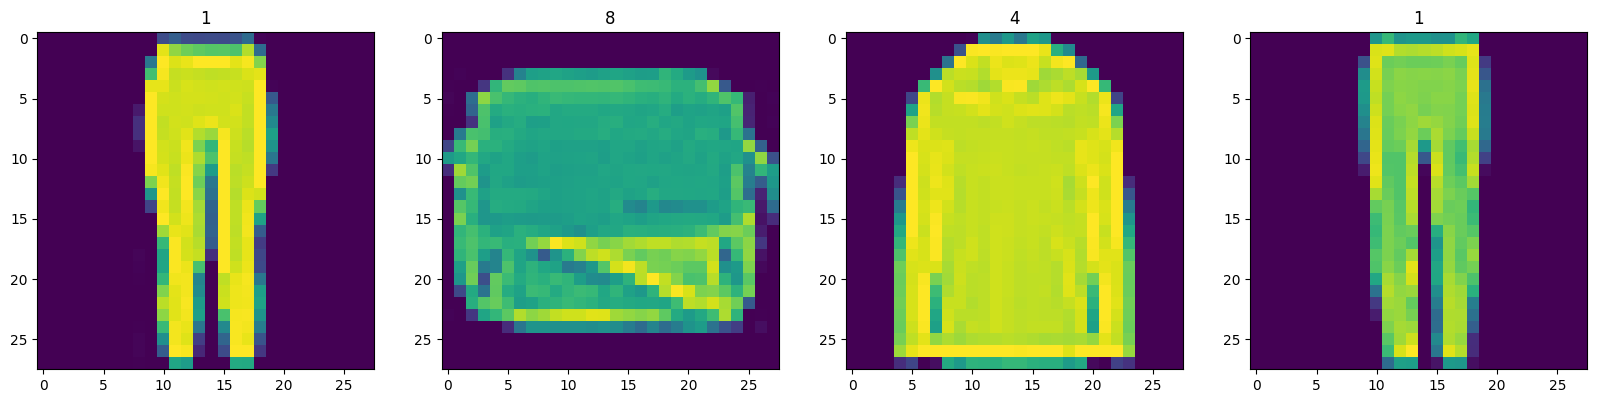

In [8]:
fig, ax = plt.subplots(ncols =4, figsize=(20,20))
for idx in range(4):
  batch = dataiterator.next()
  ax[idx].imshow(np.squeeze(batch['image']))
  ax[idx].title.set_text(batch['label'])

In [9]:
#scaling images
def scale_images(data):
  image = data['image']
  return image/255

In [10]:
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [11]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Building the neural network


##3.1 Import modelling components

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

##3.2 Building Generator

In [13]:
def build_generator():
  model = Sequential()
  #Takes in random values and reshapes it to 7*7*128
  #beginning of generated images
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  #upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  #Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 1
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 2
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  #Conv layer to get one channel
  model.add(Conv2D(1,4,padding='same',activation='sigmoid'))
  return model

In [14]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

# 3.3 Building Discriminator


In [15]:
def build_discriminator():
  model = Sequential()

  #First Conv Block
  model.add(Conv2D(32,5,input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Second Conv Block 2
  model.add(Conv2D(64,5,))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Second Conv Block 2
  model.add(Conv2D(128,5,))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Second Conv Block 2
  model.add(Conv2D(256,5,))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation = "sigmoid"))

  return model

In [16]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

# 4. Constructing Training Loop

##4.1 Setup losses and Optimizers

In [17]:
#Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
#Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [18]:
g_opt = Adam(learning_rate=0.0001)
#Learning slower than the generator
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()


##4.2 Build Subclassed Model

In [19]:
#Importing the base model
from tensorflow.keras.models import Model

In [20]:
tf.random.normal((6,128,1))

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[-1.06601790e-01],
        [ 4.73623753e-01],
        [-1.93291813e-01],
        [ 2.78839618e-01],
        [-2.83432543e-01],
        [-1.73055977e-01],
        [ 3.87310952e-01],
        [ 2.13510132e+00],
        [-1.35702801e+00],
        [ 1.04092979e+00],
        [-2.02958679e+00],
        [-6.40958965e-01],
        [ 4.08722878e-01],
        [-1.39066231e+00],
        [ 9.13703501e-01],
        [-1.25827062e+00],
        [ 1.45446968e+00],
        [ 4.57928509e-01],
        [ 3.25468540e-01],
        [-1.06301248e+00],
        [-8.67818415e-01],
        [-1.18552446e+00],
        [-7.70053267e-01],
        [-1.86269832e+00],
        [ 1.70184565e+00],
        [-2.04606518e-01],
        [-1.77507684e-01],
        [ 5.45040607e-01],
        [-1.17822933e+00],
        [-2.05380177e+00],
        [ 1.11094451e+00],
        [-2.36049592e-01],
        [ 4.88259345e-01],
        [ 1.45684958e+00],
        [-4.49858099e-01],
  

In [21]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}


In [22]:
#Create instance of subclassed
fashgan = FashionGAN(generator,discriminator)

In [23]:
#Compiling Model
fashgan.compile(g_opt,d_opt, g_loss,d_loss)

##4.3 Build Callback

In [24]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [25]:
class ModelMonitor(Callback):
  def __init__(self, numimg=3,latent_dim=128):
    self.num_img= numimg
    self.latent_dim=latent_dim

  def on_epoch_end(self,epoch,logs=None):
    random_latent_vectors=tf.random.uniform((self.num_img,self.latent_dim,1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()

    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('images',f'generated_img_{epoch}_{i}.png'))

##Training

In [26]:
from keras.api._v2.keras import callbacks
hist = fashgan.fit(ds,epochs=20)

Epoch 1/20
469/469 [==============================] - 90s 156ms/step - d_loss: 0.4435 - g_loss: 1.2175
Epoch 2/20
469/469 [==============================] - 73s 156ms/step - d_loss: 0.2760 - g_loss: 2.6860
Epoch 3/20
469/469 [==============================] - 73s 155ms/step - d_loss: 0.3339 - g_loss: 6.2755
Epoch 4/20
469/469 [==============================] - 72s 154ms/step - d_loss: 0.2777 - g_loss: 8.7500
Epoch 5/20
469/469 [==============================] - 72s 154ms/step - d_loss: 0.2741 - g_loss: 8.0649
Epoch 6/20
469/469 [==============================] - 73s 156ms/step - d_loss: 0.5371 - g_loss: 2.2196
Epoch 7/20
469/469 [==============================] - 74s 157ms/step - d_loss: 0.4962 - g_loss: 0.9041
Epoch 8/20
469/469 [==============================] - 73s 156ms/step - d_loss: 0.2730 - g_loss: 2.7093
Epoch 9/20
469/469 [==============================] - 73s 156ms/step - d_loss: 0.2712 - g_loss: 2.7404
Epoch 10/20
469/469 [==============================] - 74s 157ms/step - d

1/1 [==============================] - 0s 286ms/step


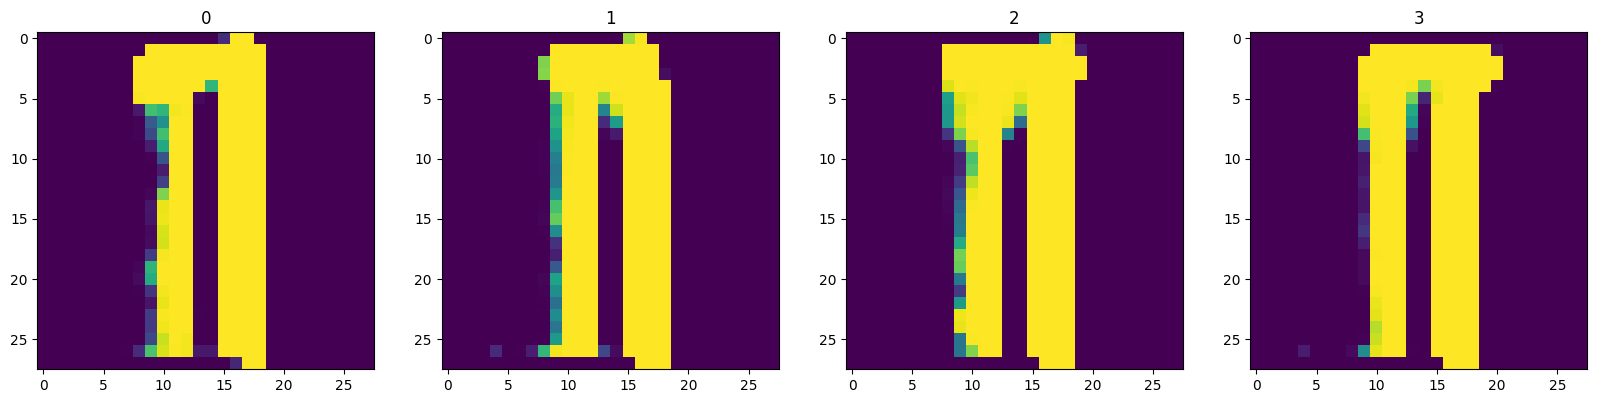

In [27]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx, img in enumerate(img):
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

In [28]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 442ms/step


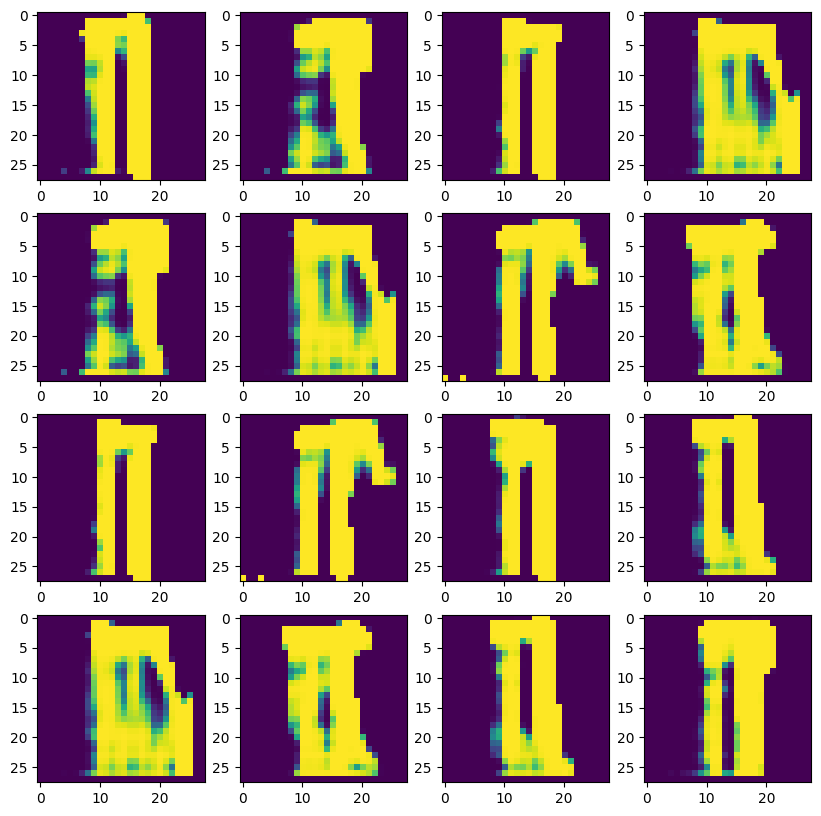

In [29]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

#Saving models

In [30]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')